# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd

c:\Users\ruoxi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [2]:
websites = pd.read_csv('../data/website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# Your code here
websites.head()

,URL,URL_LENGTH,NUMBER_SPECIAL_CHARACTERS,CHARSET,SERVER,CONTENT_LENGTH,WHOIS_COUNTRY,WHOIS_STATEPRO,WHOIS_REGDATE,WHOIS_UPDATED_DATE,TCP_CONVERSATION_EXCHANGE,DIST_REMOTE_TCP_PORT,REMOTE_IPS,APP_BYTES,SOURCE_APP_PACKETS,REMOTE_APP_PACKETS,SOURCE_APP_BYTES,REMOTE_APP_BYTES,APP_PACKETS,DNS_QUERY_TIMES,Type
0,M0_109,16,7,iso-8859-1,nginx,263.0,NaN,NaN,10/10/2015 18:21,NaN,7,0,2,700,9,10,1153,832,9,2.0,1
1,B0_2314,16,6,UTF-8,Apache/2.4.10,15087.0,NaN,NaN,NaN,NaN,17,7,4,1230,17,19,1265,1230,17,0.0,0
2,B0_911,16,6,us-ascii,Microsoft-HTTPAPI/2.0,324.0,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0.0,0
3,B0_113,17,6,ISO-8859-1,nginx,162.0,US,AK,7/10/1997 4:00,12/09/2013 0:45,31,22,3,3812,39,37,18784,4380,39,8.0,0
4,B0_403,17,6,UTF-8,NaN,124140.0,US,TX,12/05/1996 0:00,11/04/2017 0:00,57,2,5,4278,61,62,129889,4586,61,4.0,0


In [5]:
websites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1781 non-null   object 
 1   URL_LENGTH                 1781 non-null   int64  
 2   NUMBER_SPECIAL_CHARACTERS  1781 non-null   int64  
 3   CHARSET                    1774 non-null   object 
 4   SERVER                     1605 non-null   object 
 5   CONTENT_LENGTH             969 non-null    float64
 6   WHOIS_COUNTRY              1475 non-null   object 
 7   WHOIS_STATEPRO             1419 non-null   object 
 8   WHOIS_REGDATE              1654 non-null   object 
 9   WHOIS_UPDATED_DATE         1642 non-null   object 
 10  TCP_CONVERSATION_EXCHANGE  1781 non-null   int64  
 11  DIST_REMOTE_TCP_PORT       1781 non-null   int64  
 12  REMOTE_IPS                 1781 non-null   int64  
 13  APP_BYTES                  1781 non-null   int64

In [6]:
websites['WHOIS_COUNTRY'].value_counts()

WHOIS_COUNTRY
US                1103
CA                  84
ES                  63
AU                  35
PA                  21
GB                  19
JP                  11
UK                  10
CN                  10
IN                  10
FR                   9
CZ                   9
NL                   6
CH                   6
[u'GB'; u'UK']       5
KR                   5
PH                   4
BS                   4
ru                   4
AT                   4
HK                   3
us                   3
TR                   3
BE                   3
DE                   3
SC                   3
KY                   3
SE                   3
BR                   2
UY                   2
Cyprus               2
SI                   2
UA                   2
RU                   2
IL                   2
NO                   2
KG                   2
TH                   1
se                   1
LV                   1
LU                   1
United Kingdom       1
UG                  

In [7]:
websites['WHOIS_STATEPRO'].value_counts()

WHOIS_STATEPRO
CA                      372
NY                       75
WA                       65
Barcelona                62
FL                       61
Arizona                  58
California               57
ON                       45
NV                       30
UT                       29
CO                       24
PA                       23
MA                       22
IL                       19
PANAMA                   19
Ohio                     15
MO                       15
NJ                       15
Queensland               14
Utah                     13
New York                 11
VA                       10
Washington               10
TX                       10
Quebec                    9
Texas                     9
UK                        8
PRAHA                     8
DC                        8
va                        8
Illinois                  8
GA                        8
MI                        7
Missouri                  7
OH                        6
DE   

In [8]:
websites['Type'].value_counts()

Type
0    1565
1     216
Name: count, dtype: int64

In [9]:
# Your comment here
# Column "WHOIS_REGDATE" and "WHOIS_UPDATED_DATE" need to be datetime data type
# Column "CONTENT_LENGTH" has over 800 missing values, about half of the whole length, which means we need to drop this column 
# Column "Type" contains binary values, which indicates this is the variable we want to predict, and 0 stands for binign
# Column "WHOIS_COUNTRY" needs to be splitted into multiple bins, might be good to cluster them into continents, depending on what algorithm model we choose 


#### Next, evaluate if the columns in this dataset are strongly correlated.

If our dataset has strongly correlated columns, we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [10]:
numeric_columns =websites.select_dtypes(include='number')
numeric_columns.columns


Index(['URL_LENGTH', 'NUMBER_SPECIAL_CHARACTERS', 'CONTENT_LENGTH',
       'TCP_CONVERSATION_EXCHANGE', 'DIST_REMOTE_TCP_PORT', 'REMOTE_IPS',
       'APP_BYTES', 'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS',
       'SOURCE_APP_BYTES', 'REMOTE_APP_BYTES', 'APP_PACKETS',
       'DNS_QUERY_TIMES', 'Type'],
      dtype='object')

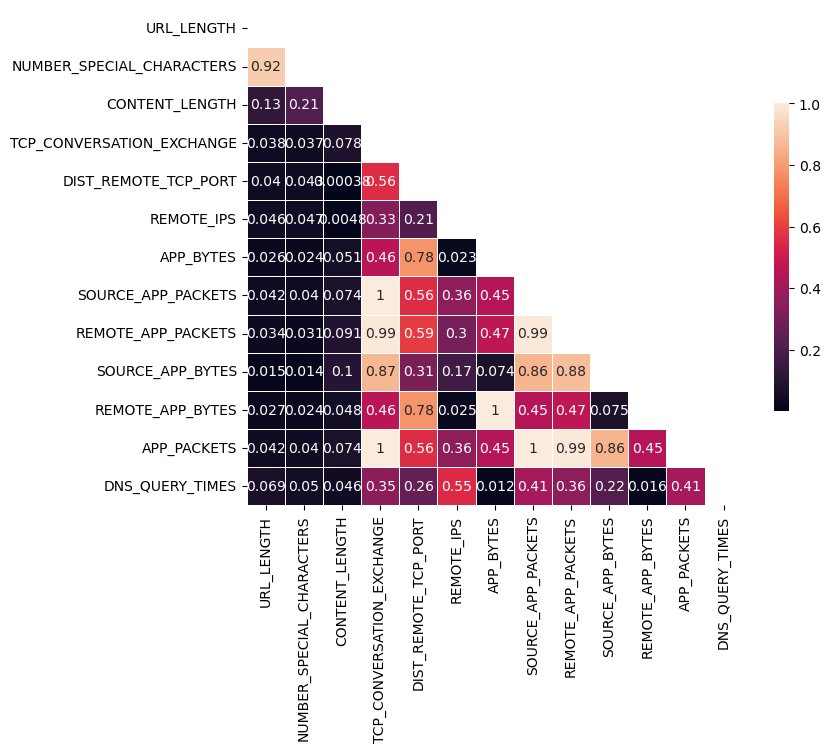

In [11]:
# Your code here

import matplotlib.pyplot as plt
import seaborn as sns

list_features =numeric_columns.drop(columns = ['Type'])
corr=np.abs(list_features.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()


In [12]:
# Your comment here
# "NUMBER_SPECIAL_CHARACTERS" and "URL_LENGTH" are very highly correlated
# "'REMOTE_APP_BYTES'" and "APP_BYTES" are very highly correlated
#  'SOURCE_APP_PACKETS', 'REMOTE_APP_PACKETS' 'APP_PACKETS' and "TCP_CONVERSATION_EXCHANGE" are very highly correlated
 


# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

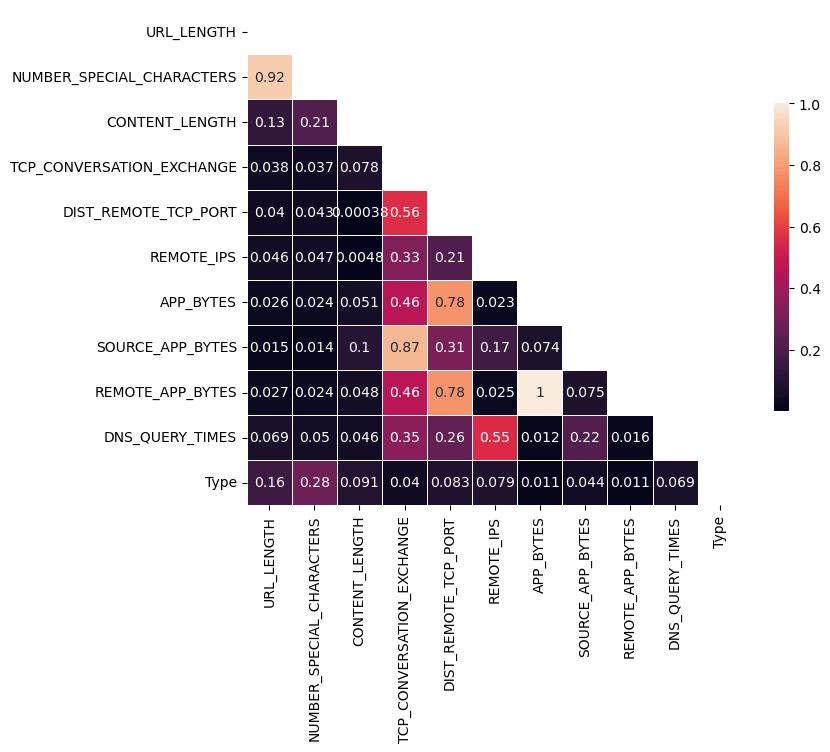

In [13]:
# Your code here
# There are three types of app packets, and for sure they have high collinearity. 
# Since the other columnd "TCP_CONVERSATION_EXCHANGE" is more specific and very likely is the core feature value from the app packets. So we only keep this one
# We'll drop the column "APP_PACKETS", “SOURCE_APP_PACKETS" and "REMOTE_APP_PACKETS" first
websites.drop(columns = ['SOURCE_APP_PACKETS', "REMOTE_APP_PACKETS", "APP_PACKETS"], inplace=True)

# Plot the heatmap
numeric_columns =websites.select_dtypes(include='number')
list_features =numeric_columns
corr=np.abs(list_features.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

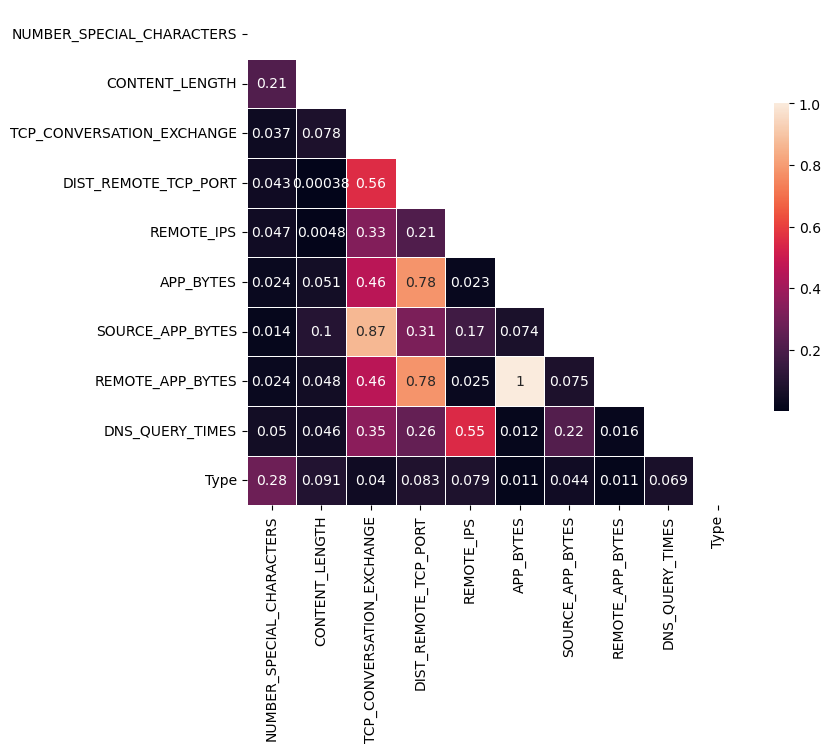

In [14]:
# Next is the column "URL_LENGTH" as the "NUMBER_SPECIAL_CHARACTERS" is more specific
websites.drop(columns = ['URL_LENGTH'], inplace = True)
# Plot the heatmap
numeric_columns =websites.select_dtypes(include='number')
list_features =numeric_columns
corr=np.abs(list_features.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

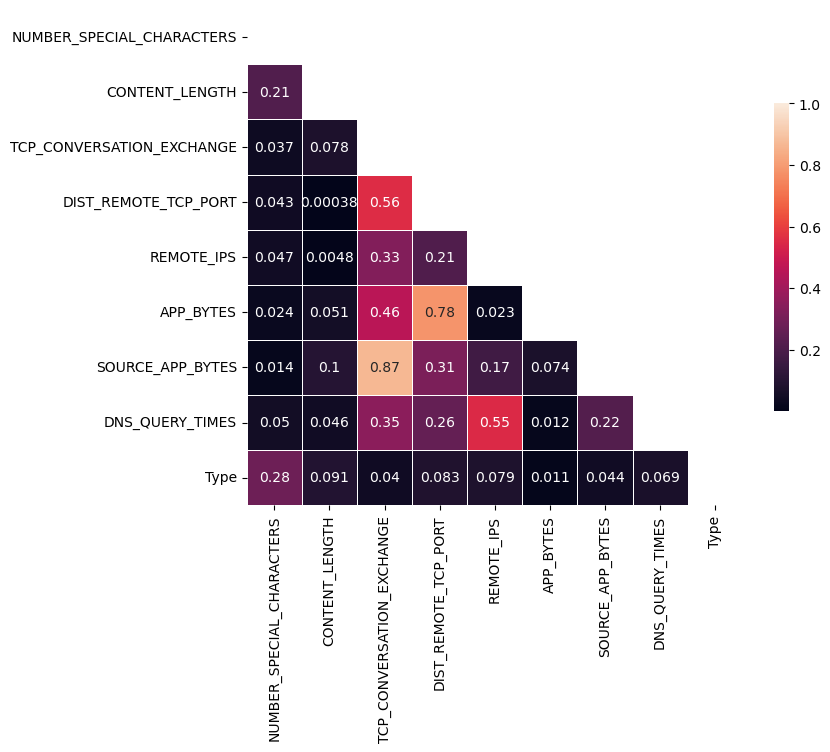

In [15]:
#Last is to remove "REMOTE_APP_BYTES" and keep "APP_BYTES"
websites.drop(columns = ['REMOTE_APP_BYTES'], inplace = True)
# Plot the heatmap
numeric_columns =websites.select_dtypes(include='number')
list_features =numeric_columns
corr=np.abs(list_features.corr())

#Set up mask for triangle representation
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 8))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [16]:
# Your code here
# Save it in a new dataframe for later use
null_value_counts = pd.DataFrame(websites.isnull().sum()).reset_index()
null_value_counts.columns = ['column_name', 'count']

In [17]:
null_value_counts

,column_name,count
0,URL,0
1,NUMBER_SPECIAL_CHARACTERS,0
2,CHARSET,7
3,SERVER,176
4,CONTENT_LENGTH,812
5,WHOIS_COUNTRY,306
6,WHOIS_STATEPRO,362
7,WHOIS_REGDATE,127
8,WHOIS_UPDATED_DATE,139
9,TCP_CONVERSATION_EXCHANGE,0


If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [18]:
# Your code here

# save the ratio in a new column in the dataframe null_value_counts
null_value_counts['ratio'] = null_value_counts['count'].apply(lambda x: x/len(websites))
null_value_counts


,column_name,count,ratio
0,URL,0,0.000000
1,NUMBER_SPECIAL_CHARACTERS,0,0.000000
2,CHARSET,7,0.003930
3,SERVER,176,0.098821
4,CONTENT_LENGTH,812,0.455924
5,WHOIS_COUNTRY,306,0.171814
6,WHOIS_STATEPRO,362,0.203257
7,WHOIS_REGDATE,127,0.071308
8,WHOIS_UPDATED_DATE,139,0.078046
9,TCP_CONVERSATION_EXCHANGE,0,0.000000


In [19]:
# Your comment here
# As we can see the column "CONTENT_LENGTH"and "WHOIS_STATEPRO" have more than 20% data missing. Therefore we will delete them
websites.drop(columns=["CONTENT_LENGTH", "WHOIS_STATEPRO"], inplace = True)

In [20]:
# For the rest of missing data, we delete the row
websites=websites.dropna()
# Then we check the missing values to confirm if it's all cleaned
websites.isnull().sum()

URL                          0
NUMBER_SPECIAL_CHARACTERS    0
CHARSET                      0
SERVER                       0
WHOIS_COUNTRY                0
WHOIS_REGDATE                0
WHOIS_UPDATED_DATE           0
TCP_CONVERSATION_EXCHANGE    0
DIST_REMOTE_TCP_PORT         0
REMOTE_IPS                   0
APP_BYTES                    0
SOURCE_APP_BYTES             0
DNS_QUERY_TIMES              0
Type                         0
dtype: int64

#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [21]:
# Examine missing values in each column
#This step is done above

# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [22]:
# Your code here
websites['WHOIS_COUNTRY'].unique()

array(['US', 'SC', 'UK', 'RU', 'AU', 'CA', 'PA', 'se', 'IN', 'LU', 'GB',
       "[u'GB'; u'UK']", 'FR', 'NL', 'UG', 'JP', 'CN', 'SE', 'SI', 'IL',
       'ru', 'KY', 'AT', 'CZ', 'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES',
       'us', 'KR', 'HK', 'UA', 'CH', 'BS', 'PK', 'IT', 'Cyprus', 'BY',
       'AE', 'IE', 'UY', 'KG'], dtype=object)

In [23]:
# Unification of the Country abbreviations
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].replace({'us': 'US', 'se': 'SE', "[u'GB'; u'UK']": 'GB', 'Cyprus': 'CY'})

websites['WHOIS_COUNTRY'].unique()

array(['US', 'SC', 'UK', 'RU', 'AU', 'CA', 'PA', 'SE', 'IN', 'LU', 'GB',
       'FR', 'NL', 'UG', 'JP', 'CN', 'SI', 'IL', 'ru', 'KY', 'AT', 'CZ',
       'PH', 'BE', 'NO', 'TR', 'LV', 'DE', 'ES', 'KR', 'HK', 'UA', 'CH',
       'BS', 'PK', 'IT', 'CY', 'BY', 'AE', 'IE', 'UY', 'KG'], dtype=object)

Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

In [24]:
# Your code here
websites['WHOIS_COUNTRY'].value_counts()

WHOIS_COUNTRY
US    960
CA     75
ES     63
AU     34
GB     22
PA     21
JP     11
UK     10
CN      9
CZ      9
IN      8
FR      8
CH      6
NL      5
BS      4
SE      4
ru      4
AT      4
KR      4
PH      4
BE      3
HK      3
TR      3
KY      3
SC      3
DE      3
RU      2
UA      2
KG      2
NO      2
IL      2
SI      2
UY      2
CY      2
BY      1
IE      1
AE      1
LU      1
IT      1
PK      1
UG      1
LV      1
Name: count, dtype: int64

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [25]:
# Your code here
#Save the top 10 countries' names in a list
top_10_country = list(websites['WHOIS_COUNTRY'].value_counts().head(10).index)
top_10_country


['US', 'CA', 'ES', 'AU', 'GB', 'PA', 'JP', 'UK', 'CN', 'CZ']

In [26]:
# Label the other coountries as "OTHER"
websites['WHOIS_COUNTRY'] = websites['WHOIS_COUNTRY'].apply(lambda x: "OTHER" if x not in top_10_country else x)

Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [27]:
# Your code here
# I already dropped the column "WHIOS_STATEPRO" during missing value handling session
websites.drop(columns=['WHOIS_REGDATE', "WHOIS_UPDATED_DATE"], inplace=True)

# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [28]:
# Your code here
websites.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, 3 to 1780
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   URL                        1307 non-null   object 
 1   NUMBER_SPECIAL_CHARACTERS  1307 non-null   int64  
 2   CHARSET                    1307 non-null   object 
 3   SERVER                     1307 non-null   object 
 4   WHOIS_COUNTRY              1307 non-null   object 
 5   TCP_CONVERSATION_EXCHANGE  1307 non-null   int64  
 6   DIST_REMOTE_TCP_PORT       1307 non-null   int64  
 7   REMOTE_IPS                 1307 non-null   int64  
 8   APP_BYTES                  1307 non-null   int64  
 9   SOURCE_APP_BYTES           1307 non-null   int64  
 10  DNS_QUERY_TIMES            1307 non-null   float64
 11  Type                       1307 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 132.7+ KB


#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [29]:
# Your code here
websites.drop(columns=["URL"], inplace=True)

#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [30]:
# Your code here
websites['CHARSET'].value_counts()

CHARSET
UTF-8           536
utf-8           288
ISO-8859-1      285
us-ascii        107
iso-8859-1       89
windows-1251      1
windows-1252      1
Name: count, dtype: int64

`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [31]:
# Your code here
websites['SERVER'].unique()

array(['nginx', 'Apache/2', 'Microsoft-HTTPAPI/2.0', 'Apache',
       'Apache/2.4.23 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'openresty/1.11.2.1', 'Apache/2.4.7 (Ubuntu)', 'nginx/1.12.0',
       'Apache/2.4.12 (Unix) OpenSSL/1.0.1e-fips mod_bwlimited/1.4',
       'cloudflare-nginx', 'openresty', 'Apache/2.2.22', 'nginx/1.8.0',
       'Apache/2.2.29 (Amazon)', 'Microsoft-IIS/7.5',
       'Apache/2.2.22 (Debian)', 'Apache/2.2.15 (CentOS)',
       'Apache/2.4.25 (Amazon) PHP/7.0.14', 'GSE',
       'Apache/2.4.23 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Pepyaka/1.11.3', 'Apache/2.4.25 (Amazon) OpenSSL/1.0.1k-fips',
       'Apache/2.2.22 (Ubuntu)', 'Apache/2.4.25', 'Tengine',
       'Apache/2.4.18 (Unix) OpenSSL/0.9.8e-fips-rhel5 mod_bwlimited/1.4',
       'Apache/2.4.10 (Debian)', 'Apache/2.4.6 (CentOS) PHP/5.6.8',
       'AmazonS3',
       'Apache/1.3.37 (Unix) mod_perl/1.29 mod_ssl/2.8.28 OpenSSL/0.9.7e-p1',
       'ATS', 'CherryPy/3.6.0', 'Apache/2.2.15

![Think Hard](../images/think-hard.jpg)

In [32]:
# Your comment here
#Maybe use the value before the first "/", so "Apache", "openresty", "Microsoft-IIS"...

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [33]:
# Your code here
server_keywords = ["Microsoft", "Apache", "nginx"]

def categorize_server(value):
    try:
        for word in server_keywords:
            if word in value:
                return word
            else:
                continue
    except:
        return "Other"


websites['SERVER'] = websites['SERVER'].apply(categorize_server)

In [34]:
# Count `SERVER` value counts here
websites['SERVER'].value_counts()

SERVER
Apache       516
nginx        329
Microsoft    154
Name: count, dtype: int64

OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [35]:
# Your code here
website_dummy = pd.get_dummies(websites[['WHOIS_COUNTRY', 'CHARSET', "SERVER"]], drop_first=True)

Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [36]:
# Your code here
website_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1307 entries, 3 to 1780
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   WHOIS_COUNTRY_CA      1307 non-null   bool 
 1   WHOIS_COUNTRY_CN      1307 non-null   bool 
 2   WHOIS_COUNTRY_CZ      1307 non-null   bool 
 3   WHOIS_COUNTRY_ES      1307 non-null   bool 
 4   WHOIS_COUNTRY_GB      1307 non-null   bool 
 5   WHOIS_COUNTRY_JP      1307 non-null   bool 
 6   WHOIS_COUNTRY_OTHER   1307 non-null   bool 
 7   WHOIS_COUNTRY_PA      1307 non-null   bool 
 8   WHOIS_COUNTRY_UK      1307 non-null   bool 
 9   WHOIS_COUNTRY_US      1307 non-null   bool 
 10  CHARSET_UTF-8         1307 non-null   bool 
 11  CHARSET_iso-8859-1    1307 non-null   bool 
 12  CHARSET_us-ascii      1307 non-null   bool 
 13  CHARSET_utf-8         1307 non-null   bool 
 14  CHARSET_windows-1251  1307 non-null   bool 
 15  CHARSET_windows-1252  1307 non-null   bool 
 16  SERVER_Micr

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(website_dummy, websites['Type'], test_size=0.2)

#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [38]:
# Your code here:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()

Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [39]:
# Your code here:
log_model.fit(X_train, y_train)

LogisticRegression()

finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [40]:
# Your code here:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = log_model.predict(X_test)
print("The confusion matrix result is:", confusion_matrix(y_test, y_pred))



The confusion matrix result is: [[225   1]
 [ 23  13]]


In [41]:
print("The accuracy score is:", accuracy_score(y_test, y_pred))

The accuracy score is: 0.9083969465648855


What are your thoughts on the performance of the model? Write your conclusions below.

In [42]:
# Your conclusions here:
# The model has 90% of accuracy and the predicted True negative is higher than the False negative, but True positive is lower than False positive
# Which indicates that the model is accurate to predict the new data correctly about True Negative

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [48]:
# Your code here:

from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)
#Force the X_test ti ve contiguous 
X_test = np.ascontiguousarray(X_test)
y_pred = knn_model.predict(X_test)

c:\Users\ruoxi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [49]:
# Your code here:
print("The confusion matrix result is:", confusion_matrix(y_test, y_pred))
print("The accuracy score is:", accuracy_score(y_test, y_pred))

The confusion matrix result is: [[222   4]
 [ 18  18]]
The accuracy score is: 0.916030534351145


In [ ]:
# The accuracy score is about 91% and the True Negative is also predicted more accurately

#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [53]:
# Your code here:

knn_model_next = KNeighborsClassifier(n_neighbors=5)
knn_model_next.fit(X_train, y_train)
#Force the X_test to be contiguous 
X_test = np.ascontiguousarray(X_test)
y_pred = knn_model_next.predict(X_test)
print("The confusion matrix result is:", confusion_matrix(y_test, y_pred))
print("The accuracy score is:", accuracy_score(y_test, y_pred))

The confusion matrix result is: [[220   6]
 [ 16  20]]
The accuracy score is: 0.916030534351145


c:\Users\ruoxi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [46]:
# Your conclusions here:

# The accuracy score remains the same, but the confusion matrix is improved a little bit in terms of True Positive

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [54]:
# Your code here

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
log_model_next = LogisticRegression()
log_model_next.fit(X_train_scaled, y_train)
y_pred = log_model_next.predict(X_test_scaled)
print("The confusion matrix result is:", confusion_matrix(y_test, y_pred))
print("The accuracy score is:", accuracy_score(y_test, y_pred))

The confusion matrix result is: [[225   1]
 [ 23  13]]
The accuracy score is: 0.9083969465648855


In [ ]:
# The accuracy score is not higher, and the confusion matrix is not significantly better either